In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 生成数据集
X1 = torch.rand(10000,1)    # 输入特征1
X2 = torch.rand(10000,1)    # 输入特征2
X3 = torch.rand(10000,1)    # 输入特征3
Y1 = ( (X1+X2+X3)<1 ).float()                        # 输出特征1
Y2 = ( (1<(X1+X2+X3)) & ((X1+X2+X3)<2) ).float()     # 输出特征2
Y3 = ( (X1+X2+X3)>2 ).float()                        # 输出特征3
Data = torch.cat([X1,X2,X3,Y1,Y2,Y3],axis=1)    # 整合数据集
Data = Data.to('cuda:0')                        # 把数据集搬到GPU上
Data.shape

torch.Size([10000, 6])

In [4]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7)      # 训练集的样本数量
test_size  = len(Data) - train_size    # 测试集的样本数量
Data = Data[torch.randperm( Data.size(0)) , : ]    # 打乱样本的顺序
train_Data = Data[:train_size, :]    # 训练集样本
test_Data  = Data[train_size:, :]    # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [5]:
class DNN(nn.Module):

    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential(          # 按顺序搭建各层
            nn.Linear(3, 5), nn.ReLU(),    # 第1层：全连接层
            nn.Linear(5, 5), nn.ReLU(),    # 第2层：全连接层
            nn.Linear(5, 5), nn.ReLU(),    # 第3层：全连接层
            nn.Linear(5, 3)                # 第4层：全连接层
        )

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)    # x即输入数据
        return y           # y即输出数据

In [6]:
model = DNN().to('cuda:0')     # 创建子类的实例，并搬到GPU上
model                          # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [7]:
# 查看内部参数（非必要）
for name, param in model.named_parameters():
    print(f"参数:{name}\n形状:{param.shape}\n数值:{param}\n")

参数:net.0.weight
形状:torch.Size([5, 3])
数值:Parameter containing:
tensor([[-0.2058,  0.1532,  0.2729],
        [-0.3887, -0.0761, -0.2727],
        [ 0.5422,  0.2349,  0.1388],
        [-0.3409,  0.3361,  0.4132],
        [ 0.1164,  0.0749,  0.2022]], device='cuda:0', requires_grad=True)

参数:net.0.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([-0.5699,  0.2446, -0.2603,  0.0846, -0.3403], device='cuda:0',
       requires_grad=True)

参数:net.2.weight
形状:torch.Size([5, 5])
数值:Parameter containing:
tensor([[-0.2643, -0.0603,  0.0046,  0.0296, -0.4312],
        [-0.2279,  0.0817, -0.2270,  0.2816,  0.1535],
        [ 0.2406, -0.1693,  0.1613,  0.1453, -0.3330],
        [-0.1861, -0.3040,  0.2141, -0.4435, -0.2773],
        [ 0.0816,  0.0825,  0.2372,  0.2435, -0.3623]], device='cuda:0',
       requires_grad=True)

参数:net.2.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([0.2704, 0.3353, 0.0438, 0.1609, 0.1698], device='cuda:0',
       requires_grad=True)

参数:net.4.weight
形状:t

In [8]:
# 损失函数的选择
loss_fn = nn.MSELoss()

In [9]:
# 优化算法的选择
learning_rate = 0.01    # 设置学习率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

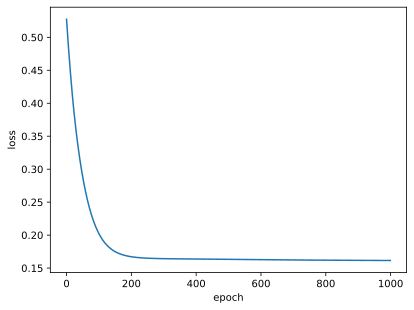

In [10]:
# 训练网络
epochs = 1000
losses = []      # 记录损失函数变化的列表

# 给训练集划分输入与输出
X = train_Data[:, :3]      # 前3列为输入特征
Y = train_Data[:, -3:]     # 后3列为输出特征

for epoch in range(epochs):
    Pred = model(X)               # 一次前向传播（BGD）
    loss = loss_fn(Pred, Y)       # 计算损失函数
    losses.append(loss.item())    # 记录损失函数的变化
    optimizer.zero_grad()         # 清理上一轮滞留的梯度
    loss.backward()               # 一次反向传播
    optimizer.step()              # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# 测试网络

# 给测试集划分输入与输出
X = test_Data[:, :3]      # 前3列为输入特征
Y = test_Data[:, -3:]     # 后3列为输出特征

with torch.no_grad():     # 该局部关闭梯度计算功能
    Pred = model(X)       # 一次前向传播（批量）
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) )    # 预测正确的样本
    total = Y.size(0)                            # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 66.03333282470703 %


In [12]:
# 保存网络
torch.save(model, 'model.pth')

In [13]:
# 直接把模型赋给新网络
new_model = torch.load('model.pth')

In [14]:
# 测试网络

# 给测试集划分输入与输出
X = test_Data[:, :3]      # 前3列为输入特征
Y = test_Data[:, -3:]     # 后3列为输出特征

with torch.no_grad():         # 该局部关闭梯度计算功能
    Pred = new_model(X)       # 在新网络中进行一次前向传播（批量）
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) )    # 预测正确的样本
    total = Y.size(0)                            # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 66.03333282470703 %
